In [1]:
# little bit of JS to prevent the outputs going into scrollable box

#%%javascript
#IPython.OutputArea.prototype._should_scroll = function(lines) {
#    return false
#}

In [2]:
# imports

from timeit import default_timer as timer # for efficiency check
import numpy as np
import pandas as pd # for data frames
from sklearn.decomposition import PCA # PCA feature eduction
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler # to scale data (preprocessing)
scaler = MinMaxScaler() # instantiate scaler
import matplotlib.pyplot as plt # to plot graphs / figures

from sklearn.cluster import KMeans # to run k-means clustering
from sklearn.metrics import silhouette_samples, silhouette_score # to evaluate cluster performance

from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor # for KNN

from sklearn.svm import SVC # SVM

# Set-up & some pre-processing

In [3]:
# read in csv (renamed to 'dataset.csv' for convenience)
# 'index_col=0' to define column headers
# 'low_memory=False' to avoid mixed type inference
data = pd.read_csv("dataset.csv", index_col=0, low_memory=False)

In [4]:
# transpose data, so Column = feature & Row = observation
if data.shape[0] < data.shape[1]:
    data = data.transpose()

# rename subgroup column to 'subgroup' for clarity
data.rename(columns={data.columns[440]: 'subgroup'}, inplace=True)

# replace supgroup string with 0 indexed int (eg. C1 = 0, C4 = 3)
data.loc[:, 'subgroup'] = [int(x[1:])-1 for x in data['subgroup']]

# print head + tail of table, to check formatting 
data

,ACTL6A_S5,ADAM9_S2,ADAMTS1_S5,ADCY7_S3,AIMP2_S5,ALKBH7_S5,ALOX5AP_S3,AMPD3_S3,APITD1_S5,APOC1_S3,...,WIPF1_S3,WNT2B_S2,WNT8B_S2,WSB2_S5,ZWILCH_S5,ZYX_S2,MMP3_S2,PLG_S5,RGS8_S5,subgroup
TCGA.02.0047.GBM.C4,745.567,4287.78,241.556,1067.64,406.736,518.148,1326.41,326.992,184.308,1370.66,...,2154.95,43.0253,0,4291.47,260.211,3867.97,0,0,46.7132,3
TCGA.02.0055.GBM.C4,1154.31,9475.54,6098.95,556.132,537.088,942.957,4211.35,361.598,319.535,3093.48,...,1947.58,44.8493,0,2494.18,467.56,11481.4,182.761,0,0.5606,3
TCGA.02.2483.GBM.C4,1498.68,2307.12,433.984,497.309,752.148,656.042,566.543,196.728,311.443,3504.38,...,1042.74,10.1319,0.8443,4128.76,682.242,5066.81,6.3325,0,4.2216,3
TCGA.02.2485.GBM.C4,1320,2685.71,911.905,316.667,785.552,953.809,307.143,80,260.462,2482.86,...,849.524,18.5714,0.9524,3609.52,440.386,5090.95,2.381,0,18.0952,3
TCGA.02.2486.GBM.C4,1404.27,2843.9,321.951,637.805,792.963,815.244,5671.95,542.683,494.488,12512.8,...,2454.88,7.3171,0.6098,2747.56,166.689,7800,3.6585,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.ZS.A9CE.LIHC.C4,472.648,178.884,135.667,35.558,1434.8,2168.49,1.6411,7.6586,268.643,189054,...,54.7046,1.6411,10.9409,1684.35,133.321,4041.58,0,91165.8,0,3
TCGA.ZS.A9CF.LIHC.C4,831.151,504.48,1062.72,126.12,492.357,2356.31,50.9993,52.3777,302.839,58041.4,...,439.008,4.1351,0.6892,982.77,383.791,1172.3,0,26629.2,0,3
TCGA.ZS.A9CG.LIHC.C3,333.162,920.651,467.524,209.769,730.687,1780.98,55.527,37.7035,284.298,155571,...,191.26,3.4276,4.7986,1372.41,97.3436,1963.32,0,125447,0,2
TCGA.ZU.A8S4.CHOL.C1,1176.62,7189.33,512.028,933.317,479.591,860.526,445.719,236.819,316.091,1932.44,...,1917.99,5.9828,0.4986,4231.83,375.979,10561.6,15.4556,117.163,0,0


In [5]:
# create reduced dataframe, 50 (random, seeded) samples from each category
# used df_reduced data set while writing code (reduce code run time)
data_small = pd.DataFrame()
for i in range(0, 6):
    data_small = data_small.append(data.loc[lambda data: data['subgroup'] == (i)].sample(n=50, random_state=64))

# print head + tail of table, to check formatting 
data_small

,ACTL6A_S5,ADAM9_S2,ADAMTS1_S5,ADCY7_S3,AIMP2_S5,ALKBH7_S5,ALOX5AP_S3,AMPD3_S3,APITD1_S5,APOC1_S3,...,WIPF1_S3,WNT2B_S2,WNT8B_S2,WSB2_S5,ZWILCH_S5,ZYX_S2,MMP3_S2,PLG_S5,RGS8_S5,subgroup
TCGA.AJ.A2QO.UCEC.C1,1181.86,3627.23,506.017,313.854,863.93,1345.91,93.9636,279.965,506.834,994.705,...,305.382,53.1434,0,2039.47,457.88,2033.31,13.0933,1.9255,0,0
TCGA.HU.A4G9.STAD.C1,1836.562708,15069.80452,111.7964209,815.1540283,573.9893505,694.8077582,11.97100131,19.03248818,252.9397594,32.67838226,...,112.4058413,6.173212975,2.904358597,1665.836955,604.8967224,1228.24699,107.3712578,18.03735,0.8518,0
TCGA.B6.A401.BRCA.C1,1166.27,2211.77,1062.61,629.832,612.497,1273.69,338.693,373.247,281.656,1226.14,...,1081.42,8.5529,1.3685,1043.45,274.714,7807.39,373.589,0,0,0
TCGA.D1.A162.UCEC.C1,993.0557014,2058.695368,1541.331533,1180.375295,609.4272138,696.5010891,198.329848,353.4117775,279.0573755,1290.738779,...,546.4849274,19.45126703,2.045356068,2001.895938,589.4591511,4247.104367,1.878192082,4.534437015,0.096683333,0
TCGA.63.A5MI.LUSC.C1,1944.26,3352.46,1234.43,374.863,805.077,269.945,187.432,125.683,308.388,177.049,...,542.623,232.787,2.1858,1025.14,1389.76,1100,30.0546,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.XF.A8HB.BLCA.C6,2480.64,2015.97,240.405,145.96,1090.01,1026.19,51.8588,625.74,615.901,383.275,...,66.97,49.7982,0.3434,2270.46,780.651,3655.19,0,7.2122,0,5
TCGA.DC.6156.READ.C6,1854.31,5716.26,494.865,1282.54,608.154,394.077,690.232,503.941,108.431,2227.85,...,1981.37,16.2407,3.3437,1675.19,568.856,5679.01,8.598,0,0,5
TCGA.22.1005.LUSC.C6,985.375,1276.05,594.15,1016.45,329.89,680.073,658.135,643.51,242.962,3489.95,...,3067.64,20.1097,0,1667.28,306.581,5276.05,67.6417,1.8282,0,5
TCGA.3U.A98I.MESO.C6,549.333,4241.78,3104.89,1077.33,337.591,542.222,624.889,239.111,165.716,1020.44,...,2315.56,337.778,0.8889,1556.44,453.876,8479.11,1.7778,0,0.8889,5


In [6]:
# define the dataset to use (ie. data_small OR data)
data_working = data

# define the features as all columns except 'subgroup'
feature_names = data_working.columns.drop('subgroup')

# separate out all features
features = data_working.loc[:, feature_names]

# separate out all subgroups
groups = data_working[['subgroup']]

# scale feature data set
data_scaled = scaler.fit_transform(features)


# QUESTION A-1: PCA projection


In [7]:
# instantiate PCA where n_components explain 70% of variance
pca70 = PCA(n_components = 0.7)

# fit feature data set to pca
data_pca = pca70.fit_transform(data_scaled)

# add reduced data to pandas dataframe
df_pca_plus = pd.DataFrame(data = data_pca, 
                      index = data_working.index)
df_pca_plus = pd.concat([df_pca_plus, groups], axis = 1)

# get the number of principle components that explain 70% of variance
evr = pca70.explained_variance_ratio_
num_pcs = evr.size
cum_var = evr.cumsum()
print('{} principal componenets explain {:.2f}% of the variance.'
      .format(num_pcs, round((cum_var[-1]*100), 2)))

39 principal componenets explain 70.23% of the variance.



# QUESTION A-2: Visualisation of the projected dataset


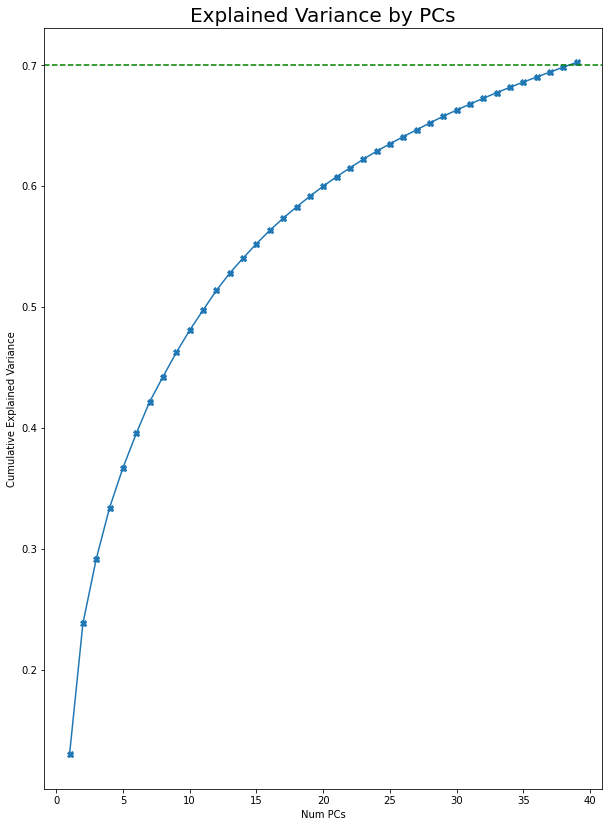

In [8]:
# plot the explained variance graph
# x = num components (num_pcs) and y = cumulative explained variance (cum_var)
plt.figure(figsize = (10,14))
plt.plot(range(1, num_pcs + 1), cum_var, marker = 'X', linestyle = '-')
plt.axhline(y=0.7, color='g', linestyle='--')

plt.title('Explained Variance by PCs', fontsize=20)
plt.xlabel('Num PCs')
plt.ylabel('Cumulative Explained Variance')

plt.show()

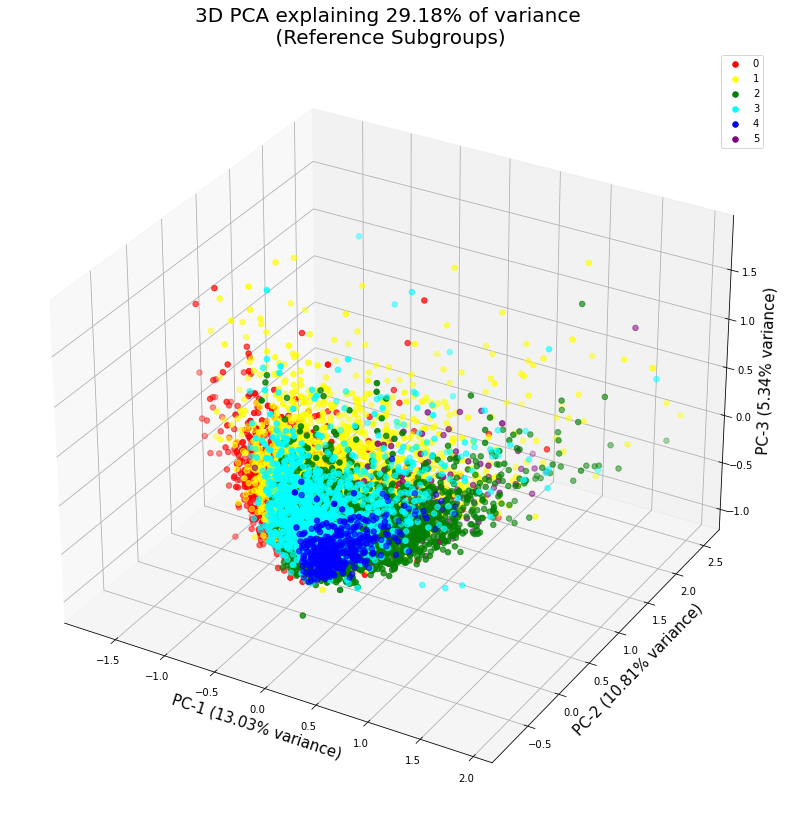

In [9]:
# set up 3d principal component plot (first 3 PC's / most explained variance)
fig = plt.figure(figsize = (14,14))
ax = fig.add_subplot(projection='3d')

# plot title
ax.set_title('3D PCA explaining {:.2f}% of variance\n (Reference Subgroups)'
             .format(round(cum_var[2] * 100, 2)), fontsize = 20)

# label axis with PC num and variance explained by that PC
ax.set_xlabel('PC-1 ({:.2f}% variance)'.format(round(evr[0] * 100, 2)), fontsize = 15)
ax.set_ylabel('PC-2 ({:.2f}% variance)'.format(round(evr[1] * 100, 2)), fontsize = 15)
ax.set_zlabel('PC-3 ({:.2f}% variance)'.format(round(evr[2] * 100, 2)), fontsize = 15)

# define subgroups and colours to use
subgrps = sorted(pd.unique(df_pca_plus['subgroup']))
colours = ['red', 'yellow', 'green', 'cyan', 'blue', 'purple']

# add data to 3d pca plot
for subgrp, colour in zip(subgrps, colours):
    indicesToKeep = df_pca_plus['subgroup'] == subgrp
    ax.scatter(df_pca_plus.loc[indicesToKeep, 0]
               , df_pca_plus.loc[indicesToKeep, 1]
               , df_pca_plus.loc[indicesToKeep, 2]
               , c = colour
               , s = 30)
ax.legend(subgrps)
ax.grid()

plt.show()

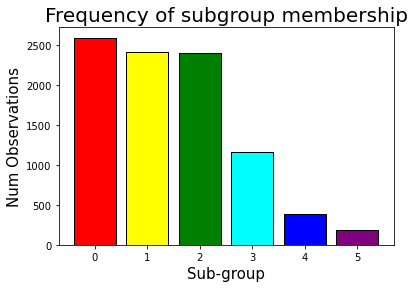

In [10]:
plt.bar(subgrps, 
        df_pca_plus['subgroup'].value_counts(),
        color = colours,
        edgecolor = 'black')
plt.title('Frequency of subgroup membership', fontsize=20)
plt.xlabel('Sub-group', fontsize=15)
plt.ylabel('Num Observations', fontsize=15)

plt.show()


# QUESTION A-3: Cluster Analysis


In [11]:
# define list for within-cluster-sum-of-squares
wcss = []

# define number of clusters to try
num_clusters = range(1,9)

# run kmeans clustering with num_clusters and store wcss
for i in num_clusters:
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 64)
    kmeans_pca.fit(df_pca_plus.iloc[:, :39])
    wcss.append(kmeans_pca.inertia_)

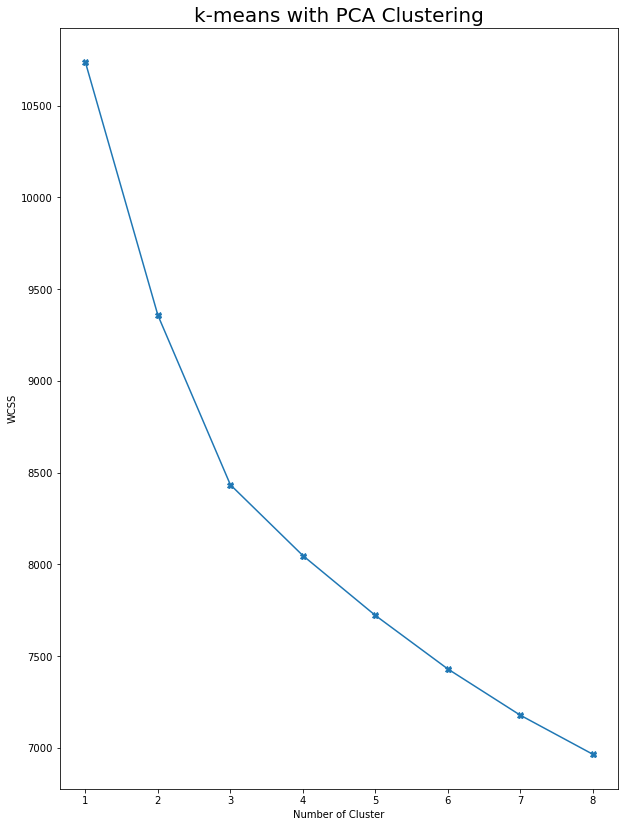

In [12]:
# create elbow plot for num_clusters wcss
plt.figure(figsize = (10,14))
plt.plot(num_clusters, wcss, marker = 'X', linestyle = '-')
plt.xlabel('Number of Cluster')
plt.ylabel('WCSS')
plt.title('k-means with PCA Clustering', fontsize=20)

plt.show()

interpretation of the above elbow plot suggests maybe 3 clusters would be best, as there appears to be a slight
elbow present at the 3rd cluster. There doesn't appear to be any elbow present at 6 clusters
which is what we might expect given the data belong to 6 separate sub-groups.


# QUESTION A-4: Visualisation of samples


In [13]:
# Find best rand seed to use (8-1024, step = 8)
seed_range = range(8, 1025, 8)
silhouette_avgs = []

print("Seeds tested:")

# get start time
start_time = timer()
for seed_num in seed_range:
    
    # instantiate kmeans clusterer with n_clusters & fit data
    clusterer = KMeans(n_clusters=6, random_state=seed_num)
    cluster_labels = clusterer.fit_predict(df_pca_plus.iloc[:, :39])
    
    # calculate avg silhouette score for n_clusters
    silhouette_avgs.append(silhouette_score(df_pca_plus.iloc[:, :39], cluster_labels))
    
    print("{} ".format(seed_num), end="", flush=True)

# get end time
end_time = timer()

print('\n{} random seeds tested, over {:.2f} seconds'
      .format(len(silhouette_avgs), round((end_time - start_time), 2)))

Seeds tested:
8 16 24 32 40 48 56 64 72 80 88 96 104 112 120 128 136 144 152 160 168 176 184 192 200 208 216 224 232 240 248 256 264 272 280 288 296 304 312 320 328 336 344 352 360 368 376 384 392 400 408 416 424 432 440 448 456 464 472 480 488 496 504 512 520 528 536 544 552 560 568 576 584 592 600 608 616 624 632 640 648 656 664 672 680 688 696 704 712 720 728 736 744 752 760 768 776 784 792 800 808 816 824 832 840 848 856 864 872 880 888 896 904 912 920 928 936 944 952 960 968 976 984 992 1000 1008 1016 1024 
128 random seeds tested, over 166.15 seconds


In [14]:
print('Best seed = {}'.format(silhouette_avgs.index(max(silhouette_avgs))*8))
rand_seed = silhouette_avgs.index(max(silhouette_avgs))*8

Best seed = 408


In [15]:
# instantiate kmeans for 6 clusters
kmeans = KMeans(n_clusters = 6, init = 'k-means++', random_state = rand_seed)

# fit predict on reduced data set
cluster_labels = kmeans.fit_predict(df_pca_plus.iloc[:, :39])

# put labels into data frame with index + column labels
cluster_labels_df = pd.DataFrame(data = cluster_labels, 
                                index = df_pca_plus.index,
                                columns = ['cluster_labels'])

# if cluster labels already exists, drop that column
# NOTE: This is only here for if I run this cell multiple times, to prevent duplicate columns
if 'cluster_labels'  in df_pca_plus.columns:
    df_pca_plus.drop(columns='cluster_labels', inplace=True)


# add predicted clusters to grp data frame
df_pca_plus = pd.concat([df_pca_plus, cluster_labels_df], axis = 1)

# show head + tail
df_pca_plus

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,subgroup,cluster_labels
TCGA.02.0047.GBM.C4,0.604731,0.013850,-0.067494,0.466528,-0.193661,-0.031991,-0.295968,-0.234224,-0.038522,0.042389,...,-0.039800,0.067535,0.045147,-0.053597,0.015800,0.001895,0.090799,0.026497,3,4
TCGA.02.0055.GBM.C4,0.632513,0.791621,0.298056,0.162257,-0.112863,-0.327943,-0.196865,-0.576752,-0.135184,-0.027422,...,0.081072,0.063927,0.081956,-0.094530,-0.055186,0.008773,-0.181192,-0.033502,3,1
TCGA.02.2483.GBM.C4,-0.296327,0.235246,0.123577,0.779925,-0.147299,0.021705,-0.220329,-0.415833,0.209102,0.116074,...,0.005556,-0.018464,-0.030549,0.047097,0.040127,0.038824,-0.005939,-0.057457,3,5
TCGA.02.2485.GBM.C4,-0.068510,-0.109534,-0.109867,0.472643,-0.062758,0.387790,-0.270499,-0.269951,0.111543,-0.061953,...,0.103780,0.036866,0.014671,0.139668,0.029988,0.121543,-0.096483,-0.026392,3,4
TCGA.02.2486.GBM.C4,0.870719,1.169939,0.372626,0.121576,0.234877,0.640220,-0.488056,-0.619194,-0.264572,0.004071,...,0.073177,-0.053064,0.088768,-0.121128,-0.001169,-0.003966,-0.097720,-0.070071,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.ZS.A9CE.LIHC.C4,0.031991,-0.565223,0.454070,-0.275952,0.405116,0.088696,-0.153324,-0.089156,-0.291557,0.177005,...,0.151159,0.032173,0.031099,0.086485,0.020343,-0.017713,-0.165846,-0.030720,3,2
TCGA.ZS.A9CF.LIHC.C4,0.040084,-0.402714,0.055757,-0.047644,0.366568,0.010784,-0.078414,-0.083076,0.069049,0.129761,...,0.020631,0.080875,0.103092,0.029902,-0.087161,0.032211,-0.091701,-0.026359,3,2
TCGA.ZS.A9CG.LIHC.C3,0.095764,-0.561850,0.264193,-0.171759,0.234407,0.008934,-0.222019,-0.003631,-0.209384,0.132924,...,-0.008410,0.070150,0.034175,0.117916,0.178352,0.043184,-0.114947,0.012020,2,2
TCGA.ZU.A8S4.CHOL.C1,0.026296,0.680765,0.254766,-0.223042,-0.303897,-0.317193,-0.120615,-0.150431,0.189266,-0.067990,...,-0.140031,-0.012042,-0.011733,-0.185665,0.007214,0.017790,0.080711,0.111485,0,3


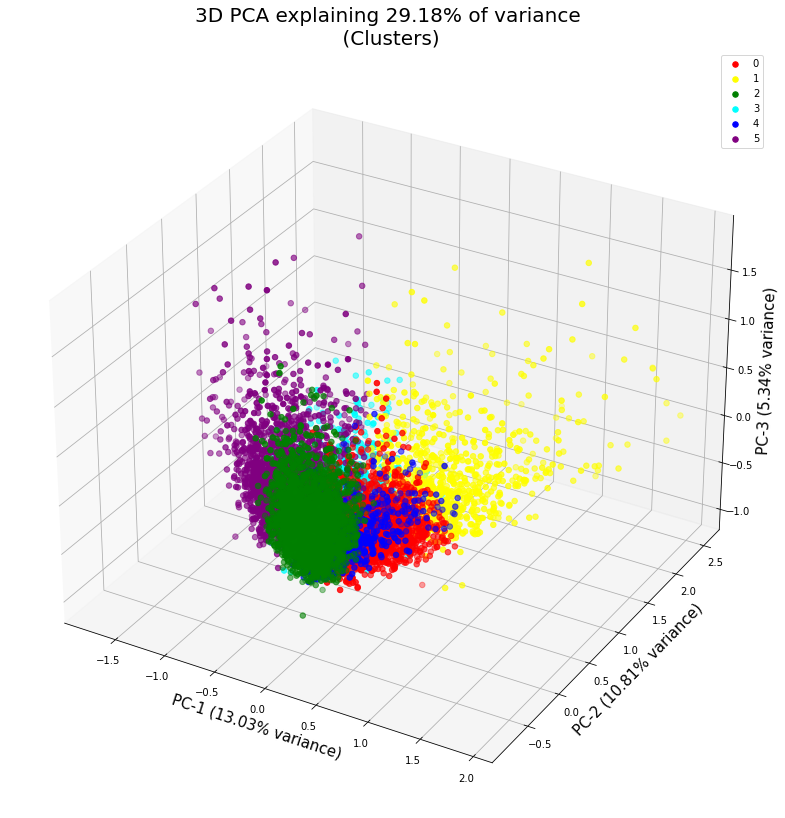

In [16]:
# set up 3d principal component plot (first 3 PC's / most explained variance)
fig = plt.figure(figsize = (14,14))
ax = fig.add_subplot(projection='3d')

# plot title
ax.set_title('3D PCA explaining {:.2f}% of variance\n (Clusters)'
             .format(round(cum_var[2] * 100, 2)), fontsize = 20)

# label axis with PC num and variance explained by that PC
ax.set_xlabel('PC-1 ({:.2f}% variance)'.format(round(evr[0] * 100, 2)), fontsize = 15)
ax.set_ylabel('PC-2 ({:.2f}% variance)'.format(round(evr[1] * 100, 2)), fontsize = 15)
ax.set_zlabel('PC-3 ({:.2f}% variance)'.format(round(evr[2] * 100, 2)), fontsize = 15)

# define subgroups and colours to use
clusters = sorted(pd.unique(df_pca_plus['cluster_labels']))

cluster_colours = list(zip(clusters, colours))

# add data to 3d pca plot
for cluster, colour in cluster_colours:
    indicesToKeep = df_pca_plus['cluster_labels'] == cluster
    ax.scatter(df_pca_plus.loc[indicesToKeep, 0]
               , df_pca_plus.loc[indicesToKeep, 1]
               , df_pca_plus.loc[indicesToKeep, 2]
               , c = colour
               , s = 30)
    
ax.legend([str(cluster) for cluster in clusters])
ax.grid()

plt.show()

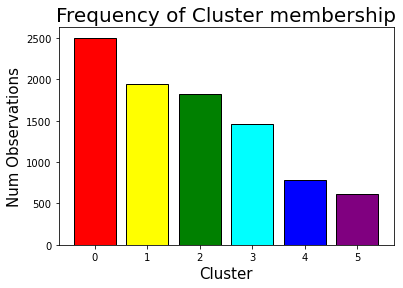

In [17]:
plt.bar(clusters, 
        df_pca_plus['cluster_labels'].value_counts(),
        color = colours,
        edgecolor = 'black')
plt.title('Frequency of Cluster membership', fontsize=20)
plt.xlabel('Cluster', fontsize=15)
plt.ylabel('Num Observations', fontsize=15)

plt.show()

We can see by comparing this visualisation of clustered samples to the reference subgroup samples
that the clusters don't appear to be a great match for the original groups


# QUESTION A-5+6: Quantitative performance evaluation


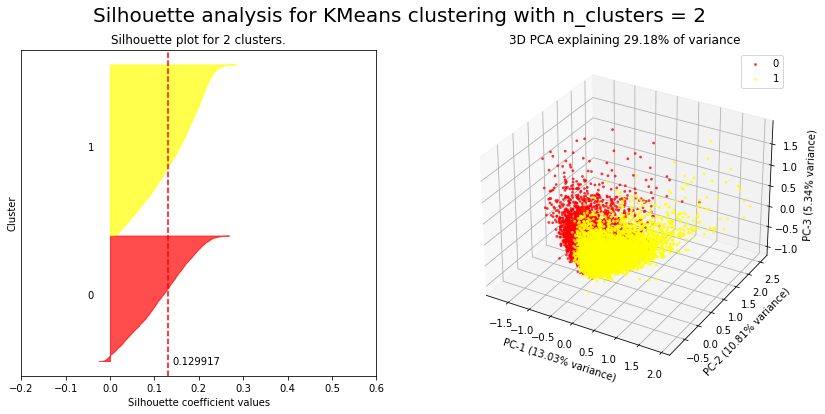

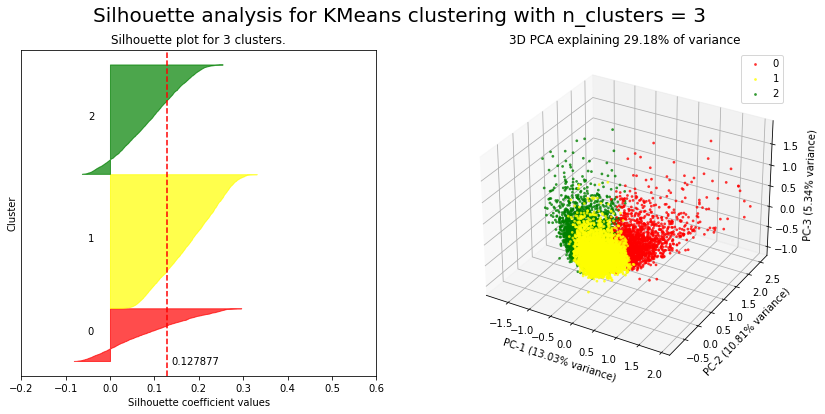

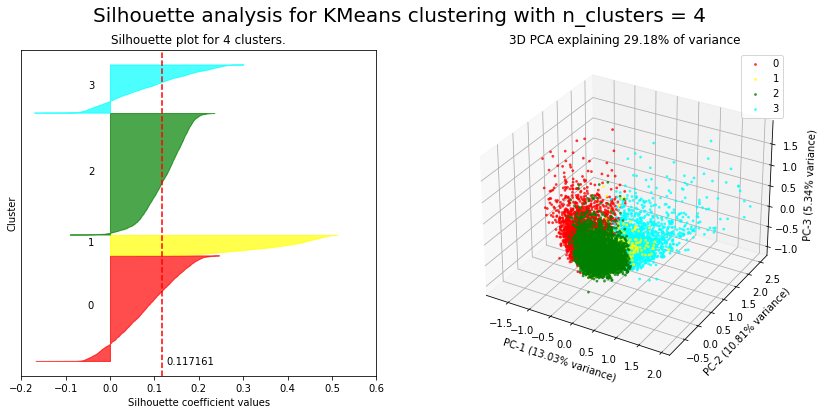

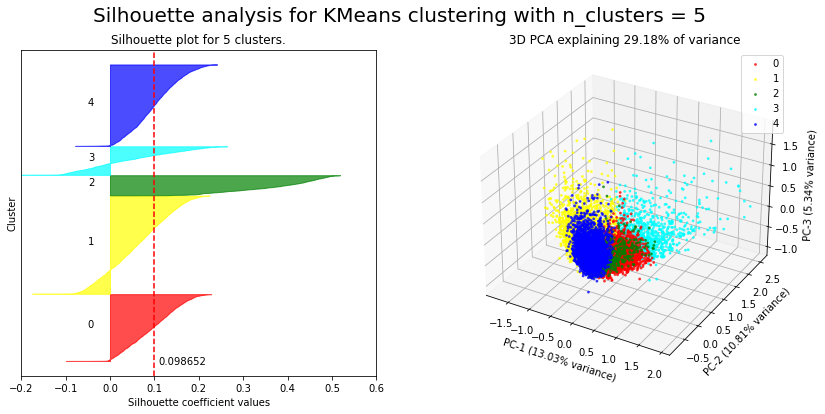

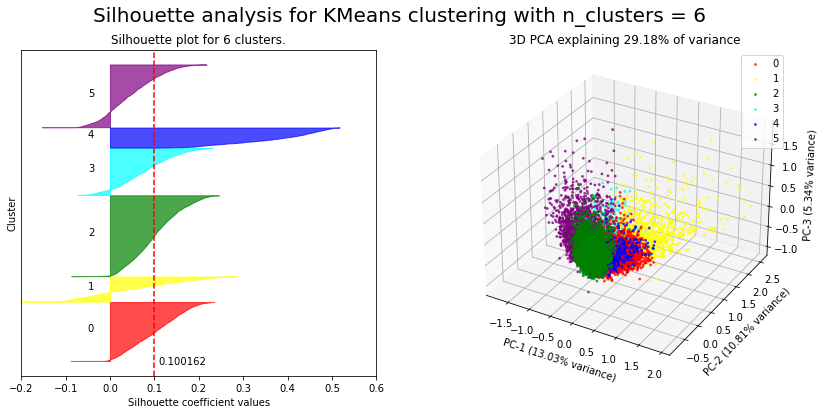

In [18]:
range_n_clusters = range(2, 7)

# dict to store silhouette scores for each n_clusters
sil_score_n_clusters = {}

for n_clusters in range_n_clusters:
    
    # Create a subplot with 1 row and 2 columns
    fig = plt.figure(figsize=(14,6))
    # ax1 = silhouette plot
    ax1 = fig.add_subplot(1, 2, 1)
    # ax2 = scatter plot
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    
    ####
    # Set up SILHOUETTE PLOT (ax1)
    ####
    
    # set x axis limits
    ax1.set_xlim([-0.2, 0.6])

    # instantiate kmeans clusterer with n_clusters & fit data
    clusterer = KMeans(n_clusters=n_clusters, random_state=rand_seed)
    cluster_labels = clusterer.fit_predict(df_pca_plus.iloc[:, :39])
    
    # calculate avg silhouette score for n_clusters
    silhouette_avg = silhouette_score(df_pca_plus.iloc[:, :39], cluster_labels)

    # calculate silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_pca_plus.iloc[:, :39], cluster_labels)
    
    # add new score to dict
    sil_score_n_clusters[n_clusters] = silhouette_avg

    y_lower = 100
    for i in range(n_clusters):
        
        # group silhouette scores by cluster
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        
        # sort silhouette scores
        ith_cluster_silhouette_values.sort()
        
        # get co-ords to plot
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # get colours from colour list
        colour = colours[i]
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=colour, edgecolor=colour, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot for {} clusters.".format(i+1))
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # plot avg score next to average line
    ax1.text((silhouette_avg + 0.01), 0, "{:.6f}".format(round(silhouette_avg, 6)))

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    
    ####
    # Set up SCATTER PLOT (ax2)
    ####

    # 2nd Plot showing the actual clusters formed
    for cluster, colour in zip(list(range(n_clusters)), colours):
        indicesToKeep = cluster_labels == cluster
        ax2.scatter(df_pca_plus.loc[indicesToKeep, 0], df_pca_plus.loc[indicesToKeep, 1], 
                    df_pca_plus.loc[indicesToKeep, 2], marker='.', s=30, lw=0, alpha=0.8, 
                    c=colour, edgecolor='k')

    # plot title
    ax2.set_title('3D PCA explaining {:.2f}% of variance'
                  .format(round(cum_var[2] * 100, 2)))

    # label axis with PC num and variance explained by that PC
    ax2.set_xlabel('PC-1 ({:.2f}% variance)'.format(round(evr[0] * 100, 2)))
    ax2.set_ylabel('PC-2 ({:.2f}% variance)'.format(round(evr[1] * 100, 2)))
    ax2.set_zlabel('PC-3 ({:.2f}% variance)'.format(round(evr[2] * 100, 2)))
    
    ax2.legend([str(cluster) for cluster in list(range(n_clusters))])

    plt.suptitle(("Silhouette analysis for KMeans clustering with n_clusters = {}"
                  .format(n_clusters)), fontsize=20)

plt.show()

We can see from the silhouette plot, the relatively low average silhouette scores (~0.1) 
and the presence of many negative scoring samples that there is a high level of overlap between
our calculated clusters.

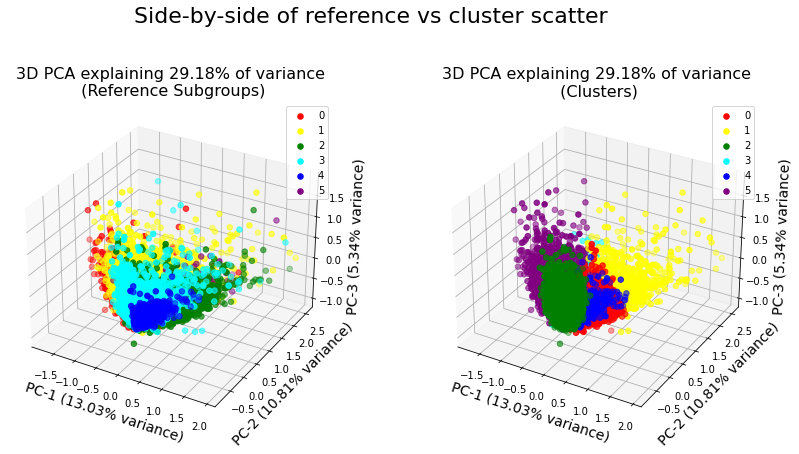

In [19]:
# Create a subplot with 1 row and 2 columns
fig = plt.figure(figsize=(14,6))
# ax1 = Reference scatter
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
# ax2 = Cluster scatter
ax2 = fig.add_subplot(1, 2, 2, projection='3d')


# set up 3d principal component plot (first 3 PC's / most explained variance)
# plot title
ax1.set_title('3D PCA explaining {:.2f}% of variance\n (Reference Subgroups)'
              .format(round(cum_var[2] * 100, 2)), fontsize = 16)

# label axis with PC num and variance explained by that PC
ax1.set_xlabel('PC-1 ({:.2f}% variance)'.format(round(evr[0] * 100, 2)), fontsize = 14)
ax1.set_ylabel('PC-2 ({:.2f}% variance)'.format(round(evr[1] * 100, 2)), fontsize = 14)
ax1.set_zlabel('PC-3 ({:.2f}% variance)'.format(round(evr[2] * 100, 2)), fontsize = 14)

# define subgroups and colours to use
subgrps = sorted(pd.unique(df_pca_plus['subgroup']))
colours = ['red', 'yellow', 'green', 'cyan', 'blue', 'purple']

# add data to 3d pca plot
for subgrp, colour in zip(subgrps, colours):
    indicesToKeep = df_pca_plus['subgroup'] == subgrp
    ax1.scatter(df_pca_plus.loc[indicesToKeep, 0]
               , df_pca_plus.loc[indicesToKeep, 1]
               , df_pca_plus.loc[indicesToKeep, 2]
               , c = colour
               , s = 30)
ax1.legend(subgrps)
ax1.grid()
    
# set up 3d principal component plot (first 3 PC's / most explained variance)
# plot title
ax2.set_title('3D PCA explaining {:.2f}% of variance\n (Clusters)'
             .format(round(cum_var[2] * 100, 2)), fontsize = 16)

# label axis with PC num and variance explained by that PC
ax2.set_xlabel('PC-1 ({:.2f}% variance)'.format(round(evr[0] * 100, 2)), fontsize = 14)
ax2.set_ylabel('PC-2 ({:.2f}% variance)'.format(round(evr[1] * 100, 2)), fontsize = 14)
ax2.set_zlabel('PC-3 ({:.2f}% variance)'.format(round(evr[2] * 100, 2)), fontsize = 14)

# define subgroups and colours to use
clusters = sorted(pd.unique(df_pca_plus['cluster_labels']))

cluster_colours = list(zip(clusters, colours))

# add data to 3d pca plot
for cluster, colour in cluster_colours:
    indicesToKeep = df_pca_plus['cluster_labels'] == cluster
    ax2.scatter(df_pca_plus.loc[indicesToKeep, 0]
               , df_pca_plus.loc[indicesToKeep, 1]
               , df_pca_plus.loc[indicesToKeep, 2]
               , c = colour
               , s = 30)
    
ax2.legend([str(cluster) for cluster in clusters])
ax2.grid()

plt.suptitle('Side-by-side of reference vs cluster scatter', y=1.1, fontsize=22)

plt.show()

By comparing the refence sub-groups with the clusters generated, we can see that they probably
aren't a great match.

In [20]:
# estimated 'best' matches for reference to cluster (eg. ref 0 = cluster 5, ref 1 = cluster 3)
# worked these out visiually from scatter plot + initial confusion matrix
adjusted_cluster_labels = [5, 3, 0, 2, 4, 1]

y_actu = pd.Series(list(df_pca_plus['subgroup']), name='Actual')
y_pred = pd.Series(list(df_pca_plus['cluster_labels']), name='Predicted')

for i in adjusted_cluster_labels:
    # replace cluster labels with label coresponding to reference
    # ( + 100 to prevent overwriting already changed labels)
    y_pred.replace(to_replace=i, 
                   value=100 + adjusted_cluster_labels.index(i), inplace=True)
    
# -100 from all labels once complete
y_pred = y_pred - 100

df_confusion = pd.crosstab(y_actu, y_pred)
print('Raw number confusion matrix (Reference vs Cluster)\n')
print(df_confusion)

Raw number confusion matrix (Reference vs Cluster)

Predicted     0     1     2    3    4    5
Actual                                    
0          1030   393   284  655    0   54
1           783  1012   175  288    0  333
2             8     1  1164  974    9  241
3           119    46   110  551  255   76
4             0     0     2   26  356    1
5             2     4    90    9    0   75


In [21]:
df_conf_norm = (df_confusion / df_confusion.sum(axis=0))*100
print('Normalised confusion matrix (Reference vs Cluster)\n')
print(df_conf_norm)

Normalised confusion matrix (Reference vs Cluster)

Predicted          0          1          2          3          4          5
Actual                                                                     
0          53.038105  26.991758  15.561644  26.168598   0.000000   6.923077
1          40.319258  69.505495   9.589041  11.506193   0.000000  42.692308
2           0.411946   0.068681  63.780822  38.913304   1.451613  30.897436
3           6.127703   3.159341   6.027397  22.013584  41.129032   9.743590
4           0.000000   0.000000   0.109589   1.038753  57.419355   0.128205
5           0.102987   0.274725   4.931507   0.359569   0.000000   9.615385


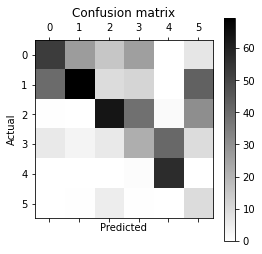

In [22]:
# NOTE: this is function originally from stackoverflow, and edited by me
def plot_conf_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    x_tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(x_tick_marks, df_confusion.columns)
    plt.xlabel(df_confusion.columns.name)

    y_tick_marks = np.arange(len(df_confusion.index))
    plt.ylabel(df_confusion.index.name)
    plt.yticks(y_tick_marks, df_confusion.index)
    
    
plot_conf_matrix(df_conf_norm)

The confusion matrices (above) show that for clusters 0, 1, 2 and 4 over 50% of samples fell into
the 'correct' cluster when compared with the reference samples.
However, for clusters 3 and more pronouncedly cluster 5 there was poor corelation with reference
at 22% and 9%, respectively.

Even among the better scoring clusters, the best performing was cluster 1, with 69.5% of clustered
samples matching the corresponding reference group, which isn't a particularly high level of 
accuracy

These poor results may be due to a number of factors related to the data-set, that are non-ideal for
k-means clustering, such as:
-  k-means strugles with clusters of varying size and density, which we have in this data-set,
   as seen by the above 'Frequency of subgroup membership' barchart
-  outliers, we can see from the 3D data visualisation that there are some data that are quite
   separated from the clusters
-  'curse of dimensionality' even after runing PCA we need ~40 features to explain ~70% of the
   variance

To adress these issues with k-means clustering, we could try different clusting algorithms such as
K-medoids clustering or PAM (Partitioning Around Medoids) which is less sensitive to outliers
compared to k-means.


# Question B: Supervised Learning - Classification

# (Optimal Model Complexity)


In [23]:
# get data
x = pd.DataFrame(df_pca_plus.iloc[:, :39])

# get actual groups
y = y_actu.values

In [24]:
# divide into training and test data (70% train, 30% test)
# random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 64)

In [25]:
# set up lists to hold ouputs
train_score = []
test_score = []
k_vals = []

# selected range 1-101 as it contains k=sqrt(n) (n= num samples)
# sugested to be a good starting point to find optimal k
k_to_test = range(1, 101)

# get start time
start_time = timer()

# loop through k_to_test and enter outputs to lists
for k in k_to_test:
    k_vals.append(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    
    tr_score = knn.score(X_train, y_train)
    train_score.append(tr_score)
    
    te_score = knn.score(X_test, y_test)
    test_score.append(te_score)
    
# get end time
end_time = timer()

print("{} k's tested, over {:.2f} seconds"
      .format(len(k_vals), round((end_time - start_time), 2)))

100 k's tested, over 128.64 seconds


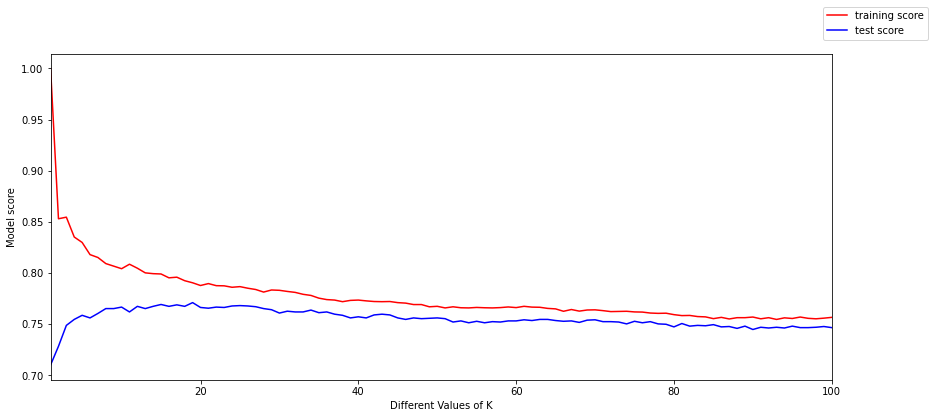

In [26]:
plt.figure(figsize=(14,6))
plt.xlabel('Different Values of K')
plt.xlim(1, len(k_vals))
plt.ylabel('Model score')
plt.plot(k_vals, train_score, color = 'r', label = "training score")
plt.plot(k_vals, test_score, color = 'b', label = 'test score')
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
plt.show()

In [27]:
print("Peak test performance k={}".format(test_score.index(max(test_score)) + 1))
print()
print("k=10 : {:.2f}% test accuracy".format(test_score[9]*100))
print("k=16 : {:.2f}% test accuracy".format(test_score[15]*100))

Peak test performance k=19

k=10 : 76.66% test accuracy
k=16 : 76.73% test accuracy


From inspecting the (above) bias-variance trade off graph, we can see that peak test performance occurs at k=10, with performance slowly decreasing as k increases.

Despite k=10 having peak test performance, k=16 may be a more appropriate value, as the higher k value will increase robustness of the algorithm (ie. be less influenced by noise / not over-fit) and the accuracy is only marginaly decreased (~0.2%) from that of k=10 (see above output)

In [28]:
k = 16

knn = KNeighborsClassifier(n_neighbors = k)

#Fit the model
knn.fit(X_train,y_train)

#get the score
print("{:.2f} test accuracy at n_neighbors = {}\n({:.2f} training accuracy)"
      .format(test_score[15]*100, k, train_score[15]*100))

76.73 test accuracy at n_neighbors = 16
(79.52 training accuracy)



# Question C: SVM model development


In [29]:
# copy df to work with
svm_df = df_pca_plus.copy()

# drop cluster columns made earlier, don't need them
svm_df.drop(columns=['cluster_labels'], inplace=True)

# print head+tail
svm_df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,subgroup
TCGA.02.0047.GBM.C4,0.604731,0.013850,-0.067494,0.466528,-0.193661,-0.031991,-0.295968,-0.234224,-0.038522,0.042389,...,0.037379,-0.039800,0.067535,0.045147,-0.053597,0.015800,0.001895,0.090799,0.026497,3
TCGA.02.0055.GBM.C4,0.632513,0.791621,0.298056,0.162257,-0.112863,-0.327943,-0.196865,-0.576752,-0.135184,-0.027422,...,0.038526,0.081072,0.063927,0.081956,-0.094530,-0.055186,0.008773,-0.181192,-0.033502,3
TCGA.02.2483.GBM.C4,-0.296327,0.235246,0.123577,0.779925,-0.147299,0.021705,-0.220329,-0.415833,0.209102,0.116074,...,-0.063214,0.005556,-0.018464,-0.030549,0.047097,0.040127,0.038824,-0.005939,-0.057457,3
TCGA.02.2485.GBM.C4,-0.068510,-0.109534,-0.109867,0.472643,-0.062758,0.387790,-0.270499,-0.269951,0.111543,-0.061953,...,0.047012,0.103780,0.036866,0.014671,0.139668,0.029988,0.121543,-0.096483,-0.026392,3
TCGA.02.2486.GBM.C4,0.870719,1.169939,0.372626,0.121576,0.234877,0.640220,-0.488056,-0.619194,-0.264572,0.004071,...,0.325598,0.073177,-0.053064,0.088768,-0.121128,-0.001169,-0.003966,-0.097720,-0.070071,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.ZS.A9CE.LIHC.C4,0.031991,-0.565223,0.454070,-0.275952,0.405116,0.088696,-0.153324,-0.089156,-0.291557,0.177005,...,0.083274,0.151159,0.032173,0.031099,0.086485,0.020343,-0.017713,-0.165846,-0.030720,3
TCGA.ZS.A9CF.LIHC.C4,0.040084,-0.402714,0.055757,-0.047644,0.366568,0.010784,-0.078414,-0.083076,0.069049,0.129761,...,0.060691,0.020631,0.080875,0.103092,0.029902,-0.087161,0.032211,-0.091701,-0.026359,3
TCGA.ZS.A9CG.LIHC.C3,0.095764,-0.561850,0.264193,-0.171759,0.234407,0.008934,-0.222019,-0.003631,-0.209384,0.132924,...,-0.039784,-0.008410,0.070150,0.034175,0.117916,0.178352,0.043184,-0.114947,0.012020,2
TCGA.ZU.A8S4.CHOL.C1,0.026296,0.680765,0.254766,-0.223042,-0.303897,-0.317193,-0.120615,-0.150431,0.189266,-0.067990,...,0.090505,-0.140031,-0.012042,-0.011733,-0.185665,0.007214,0.017790,0.080711,0.111485,0


In [30]:
# instead of using train_test_split method to split dataset, I'll do it manually so that i can
# get an even sample from each subgroup

# fraction of samples for test data
test_frac = 0.2

# create empty df's
df_test = pd.DataFrame()
df_train = pd.DataFrame()

# loop through range from 0 to num of unique entries -> subgroups 0 indexed
for i in range(0, svm_df['subgroup'].nunique()):
    # loc all samples from i subgroup and append 'test_frac' fraction to df_test
    # random_state set for reproducibility
    df_test = df_test.append(svm_df.loc[lambda svm_df: svm_df['subgroup'] == (i)].sample(frac=test_frac, random_state=64))
    
# add all other samples to df_train (concat original df and test df and drop all dupes)
df_train = pd.concat([svm_df, df_test]).drop_duplicates(keep=False)
# sort df_train by subgroup - just for consistency, as df_test is sorted this way due to loop
df_train.sort_values(by=['subgroup'], inplace=True)

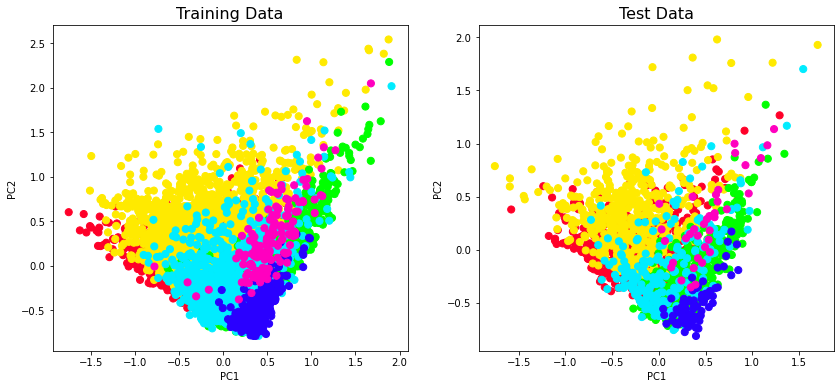

In [31]:
# quick 2d side-by-side to visualise training and test data to make sure it looks right!

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# training data plot
ax1.scatter(df_train.iloc[:, 0], 
            df_train.iloc[:, 1], 
            c=df_train.iloc[:, 39], 
            s=50, cmap='gist_rainbow')
ax1.set_title("Training Data", fontsize = 16)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')

# test data plot
ax2.scatter(df_test.iloc[:, 0], 
            df_test.iloc[:, 1], 
            c=df_test.iloc[:, 39], 
            s=50, cmap='gist_rainbow')
ax2.set_title("Test Data", fontsize = 16)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')

plt.show()

Looks good - can see there is a decent distribution of samples from each subgroup in both test and training splits

In [32]:
# get param names to construct param grid
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [33]:
# test a wide range of cost+gamma's to start with
param_grid = [{'C': range(1, 11, 1), 
               'gamma': range(1, 11, 1), 
               'kernel': ['rbf']}]

svc = SVC()

# get start time
start_time = timer()

grid_cv = GridSearchCV(svc, param_grid)
grid_cv.fit(df_train.iloc[:, :39], df_train.iloc[:, 39])

# get end time
end_time = timer()

print("{} iterations tested, over {:.2f} seconds\n"
      .format(len(grid_cv.cv_results_['rank_test_score']), (end_time - start_time)))

100 iterations tested, over 1431.33 seconds



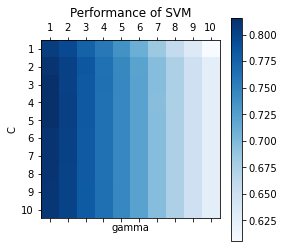

In [34]:
# get params into DF (easier to access data series)
params = pd.DataFrame(grid_cv.cv_results_['params'])

# create crosstab of C + Gamma with mean_test_score
performance_map = pd.crosstab(round(params['C'], 2), params['gamma'], grid_cv.cv_results_['mean_test_score'], aggfunc='mean')

# use the 'plot_confusion_matrix' method from earlier
plot_conf_matrix(performance_map, title = 'Performance of SVM', cmap=plt.cm.Blues)

In [35]:
print("The best parameters are {} with a score of {:0.4f}"
      .format(grid_cv.best_params_, grid_cv.best_score_))

The best parameters are {'C': 5, 'gamma': 1, 'kernel': 'rbf'} with a score of 0.8161


In [36]:
# test a wide range of cost+gamma's to start with
param_grid1 = [{'C': np.arange(4.5, 5.75, 0.25), 
               'gamma': np.arange(0.25, 1.5, 0.25), 
               'kernel': ['rbf']}]

svc = SVC()

# get start time
start_time = timer()

grid_cv1 = GridSearchCV(svc, param_grid1)
grid_cv1.fit(df_train.iloc[:, :39], df_train.iloc[:, 39])

# get end time
end_time = timer()

print("{} iterations tested, over {:.2f} seconds\n"
      .format(len(grid_cv1.cv_results_['rank_test_score']), (end_time - start_time)))

25 iterations tested, over 117.66 seconds



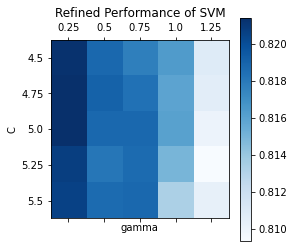

In [40]:
# get params into DF (easier to access data series)
params1 = pd.DataFrame(grid_cv1.cv_results_['params'])

# create crosstab of C + Gamma with mean_test_score
performance_map1 = pd.crosstab(round(params1['C'], 2), params1['gamma'], grid_cv1.cv_results_['mean_test_score'], aggfunc='mean')

# use the 'plot_confusion_matrix' method from earlier
plot_conf_matrix(performance_map1, title = 'Refined Performance of SVM', cmap=plt.cm.Blues)

In [38]:
print("The best parameters are {} with a score of {:0.4f}"
      .format(grid_cv1.best_params_, grid_cv1.best_score_))

The best parameters are {'C': 4.75, 'gamma': 0.25, 'kernel': 'rbf'} with a score of 0.8214


As we can see from the above 'Performance of SVM' plots, and the 'grid_cv1.best_params_' attribute, from the values tested cost=4.75 and gamma=0.25 were the best performing hyperparameters for the SVM model.

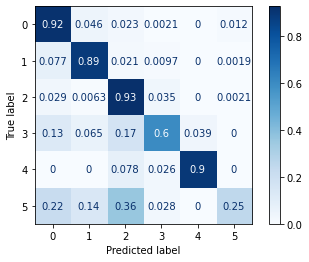

In [39]:
# instantiate model with best params from grid search
clf = SVC(C=grid_cv1.best_params_['C'], gamma=grid_cv1.best_params_['gamma'], kernel='rbf')

# train the model with the split training data
clf.fit(df_train.iloc[:, :39], df_train.iloc[:, 39])

# validate trained model (clf) with test data, and plot confusion matrix to visualise performance
ax = plot_confusion_matrix(clf, df_test.iloc[:, :39], df_test.iloc[:, 39], 
                            cmap=plt.cm.Blues, 
                            normalize='true')

plt.show()

As you can see from the above confusion matrix, the models performance for identifying subgroups 0, 1, 2 and 4 (originally C1, C2, C3, and C5) was quite good at around ~90% accuracy with few discordant samples.
However, the accuracy for subgroup 3 (originally C4) is quite a bit worse at ~60%. The accuracy for subgroup 5 (originally C6) is even worse at only ~25%.

One improvement that could be made to the model is using a more specific scoring metric than built in score (default scoring = sklearn.metrics.accuracy_score) during parameter search to evaluate the optimal values of cost and gamma (hyperperameters).
To improve the model, we could define a different 'scoring' parameter eg. GridSearchCV(scoring=‘balanced_accuracy’) to use a balanced accuracy score (sklearn.metrics.balanced_accuracy_score) which may perform better with our data set, as we have an imbalanced dataset.

Another potential improvement we could make to refining optimal hyperparameters (cost and gamma values) would be to run more iterations of the grid search, with a smaller step / interval eg. intervals of 0.01.
However, this would take considerably more time to run as the current model initially ran 100 iterations and took ~24 minutes and a further 25 iterations taking another ~2 minutes.